# Forecasting Monthly Airline Passengers with Feature Engineering  
## Capturing Trend and Seasonality in a Classic Time Series

In this example, we apply the same feature-engineering ideas to the **International Airline Passengers** dataset.

This dataset contains:

- Monthly totals of international airline passengers  
- From **January 1949 to December 1960**  
- With strong **trend** and **seasonality**

Our goal:

- Transform the time series into a **supervised learning** dataset  
- Use **lag features**, **rolling averages**, and **calendar features**  
- Train a machine learning model (Random Forest)  
- Evaluate it against a **naive baseline**  
- Generate a simple **future forecast**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

plt.style.use("default")

# Load Airline Passengers dataset
url_air = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
air = pd.read_csv(url_air)

# Parse dates and set index
air["Month"] = pd.to_datetime(air["Month"])
air.set_index("Month", inplace=True)
air.rename(columns={"Passengers": "Passengers"}, inplace=True)

air.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Visualizing Airline Passengers

The airline passengers series shows:

- Upward **trend** over time  
- Clear **within-year seasonality** (peaks and troughs each year)  
- Increasing variability as the series grows

We start by plotting the raw series to see these patterns.


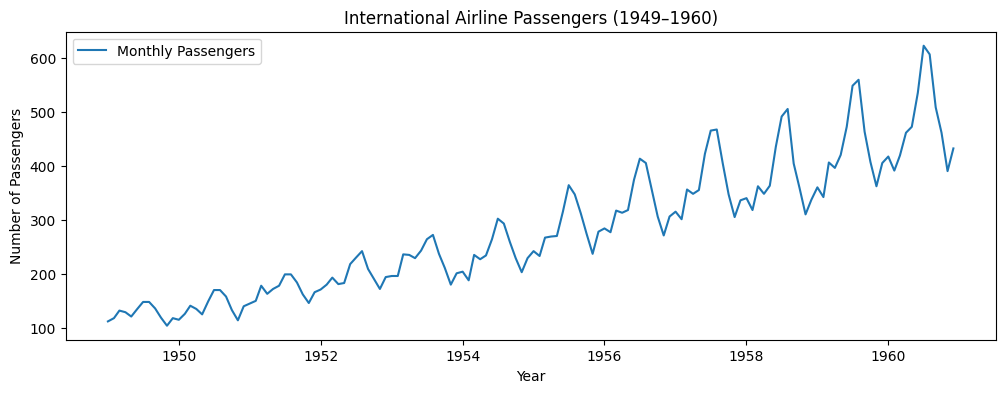

In [2]:
plt.figure(figsize=(12,4))
plt.plot(air["Passengers"], label="Monthly Passengers")
plt.title("International Airline Passengers (1949–1960)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


## Optional Step: Log Transform to Stabilize Variance

Because the variance increases with the level of the series (larger swings in later years),  
we apply a **log transform** to stabilize the variance. This often helps models learn more easily.


In [3]:
air["Passengers_log"] = np.log(air["Passengers"])
air[["Passengers", "Passengers_log"]].head()


,Passengers,Passengers_log
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


## Feature Engineering for Airline Passengers

We now engineer features that capture:

1. **Short-term memory** – lag features  
   - `lag_1`, `lag_2`, `lag_12` (1, 2, and 12 months ago)

2. **Trend and smoothed behavior** – rolling features  
   - 12-month rolling mean of the log passengers

3. **Calendar effects** – month-of-year  
   - One-hot encoded month to capture seasonal pattern


In [4]:
air_feat = air.copy()

# Lag features (based on log-transformed series)
air_feat["lag_1"] = air_feat["Passengers_log"].shift(1)
air_feat["lag_2"] = air_feat["Passengers_log"].shift(2)
air_feat["lag_12"] = air_feat["Passengers_log"].shift(12)

# Rolling 12-month mean of log passengers (trend)
air_feat["roll_mean_12"] = air_feat["Passengers_log"].rolling(window=12).mean()

# Calendar features: month as categorical one-hot
air_feat["month"] = air_feat.index.month
air_feat = pd.get_dummies(air_feat, columns=["month"], drop_first=True)

air_feat.head(15)


,Passengers,Passengers_log,lag_1,lag_2,lag_12,roll_mean_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Month,,,,,,,,,,,,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1949-02-01,118,4.770685,4.718499,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False
1949-03-01,132,4.882802,4.770685,4.718499,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False
1949-04-01,129,4.859812,4.882802,4.770685,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False
1949-05-01,121,4.795791,4.859812,4.882802,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False
1949-06-01,135,4.905275,4.795791,4.859812,NaN,NaN,False,False,False,False,True,False,False,False,False,False,False
1949-07-01,148,4.997212,4.905275,4.795791,NaN,NaN,False,False,False,False,False,True,False,False,False,False,False
1949-08-01,148,4.997212,4.997212,4.905275,NaN,NaN,False,False,False,False,False,False,True,False,False,False,False
1949-09-01,136,4.912655,4.997212,4.997212,NaN,NaN,False,False,False,False,False,False,False,True,False,False,False


## Preparing the Supervised Dataset

The first few rows will contain NaNs due to lags and rolling windows.  
We drop these rows, then construct:

- **X**: all engineered features  
- **y**: the log-transformed passenger counts


In [5]:
air_model = air_feat.dropna()

X_air = air_model.drop(["Passengers", "Passengers_log"], axis=1)
y_air = air_model["Passengers_log"]

X_air.head(), y_air.head()


(               lag_1     lag_2    lag_12  roll_mean_12  month_2  month_3  \
 Month                                                                      
 1950-01-01  4.770685  4.644391  4.718499      4.838381    False    False   
 1950-02-01  4.744932  4.770685  4.770685      4.843848     True    False   
 1950-03-01  4.836282  4.744932  4.882802      4.849344    False     True   
 1950-04-01  4.948760  4.836282  4.859812      4.853133    False    False   
 1950-05-01  4.905275  4.948760  4.795791      4.855843    False    False   
 
             month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
 Month                                                                        
 1950-01-01    False    False    False    False    False    False     False   
 1950-02-01    False    False    False    False    False    False     False   
 1950-03-01    False    False    False    False    False    False     False   
 1950-04-01     True    False    False    False    False    Fals

In [6]:
X_air_train, X_air_test, y_air_train, y_air_test = train_test_split(
    X_air, y_air, test_size=0.2, shuffle=False
)

len(X_air_train), len(X_air_test)


(105, 27)

## Naive Baseline: Predict Next Month = This Month

For a baseline forecast, we simply predict:

> Next month’s log-passenger count = this month’s log-passenger count.

This corresponds to using `lag_1` alone.


In [7]:
naive_air_preds = X_air_test["lag_1"].values
naive_air_mae = mean_absolute_error(y_air_test, naive_air_preds)
naive_air_mae


0.09927833000862903

In [8]:
rf_air = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf_air.fit(X_air_train, y_air_train)

rf_air_preds_log = rf_air.predict(X_air_test)
rf_air_mae = mean_absolute_error(y_air_test, rf_air_preds_log)
rf_air_mae


0.06806505176552295

## Comparing Model vs Baseline

We compare:

- **Naive MAE** (lag_1 only)
- **Random Forest MAE** (lags + rolling + month dummies)

A lower MAE for the Random Forest indicates our feature engineering and model are capturing trend and seasonality better than a trivial persistence model.


In [9]:
print("Naive baseline MAE (log scale):", naive_air_mae)
print("Random Forest MAE (log scale):", rf_air_mae)


Naive baseline MAE (log scale): 0.09927833000862903
Random Forest MAE (log scale): 0.06806505176552295


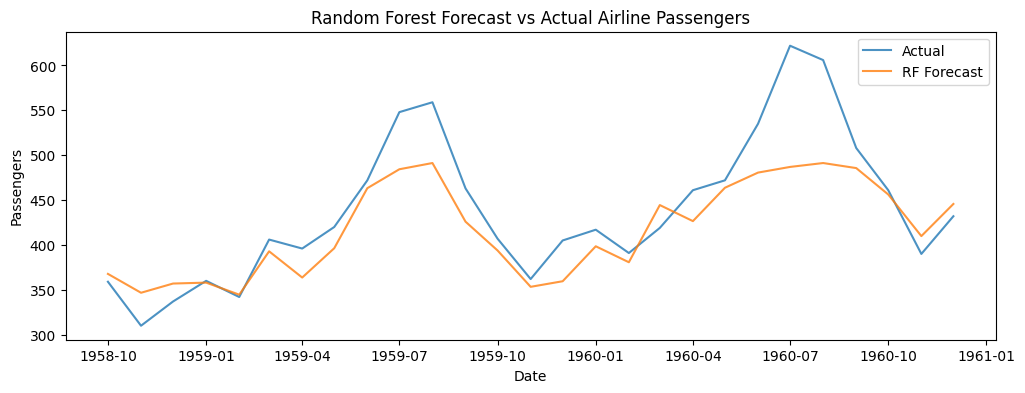

In [10]:
# Convert predictions back from log scale for plotting
rf_air_preds = np.exp(rf_air_preds_log)
y_air_test_actual = np.exp(y_air_test)

plt.figure(figsize=(12,4))
plt.plot(y_air_test_actual.index, y_air_test_actual.values, label="Actual", alpha=0.8)
plt.plot(y_air_test_actual.index, rf_air_preds, label="RF Forecast", alpha=0.8)
plt.title("Random Forest Forecast vs Actual Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


## Forecasting the Next Month's Passengers

To forecast the next month:

1. Take the last available row of features  
2. Drop the targets  
3. Use the trained Random Forest model to predict the next log-passenger count  
4. Exponentiate to get back to the passenger scale


In [11]:
last_air_row = air_feat.tail(1)
X_air_future = last_air_row.drop(["Passengers", "Passengers_log"], axis=1)

future_air_log = rf_air.predict(X_air_future)[0]
future_air = np.exp(future_air_log)

future_air


445.6761934621396

## References (Example 2)

- Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice*. OTexts.  
- Brownlee, J. (2017). *Time Series Forecasting with Python*. Machine Learning Mastery.  
- Dataset: *International Airline Passengers*. Available via Jason Brownlee’s Datasets repository.  
- pandas Documentation: https://pandas.pydata.org  
- scikit-learn Documentation: https://scikit-learn.org


# Forecasting Monthly Milk Production with Feature Engineering  
## Modeling Smooth Seasonality in Production Data

In this example, we use a **monthly milk production** time series to show how the same feature-engineering pipeline can be applied to a different domain.

The dataset contains:

- **Monthly milk production (pounds per cow)**  
- Roughly from 1962 to 1975  
- Strong seasonal pattern with a smoother long-term trend

We will:

- Load and visualize the series  
- Engineer lag and rolling features  
- Train a Random Forest regressor  
- Compare against a naive baseline  
- Produce a one-step-ahead forecast


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

plt.style.use("default")

# Load Monthly Milk Production dataset
url_milk = "https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv"
milk = pd.read_csv(url_milk)

milk.head()


,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [13]:
# The CSV has columns: Month, Monthly milk production (pounds per cow)
milk.columns = ["Month", "Milk"]

milk["Month"] = pd.to_datetime(milk["Month"])
milk.set_index("Month", inplace=True)

milk.head()


,Milk
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


## Visualizing Milk Production

We first plot the milk production series to see:

- Seasonal patterns across years  
- Slow upward trend  
- Overall smooth behavior compared to highly volatile series like stock prices


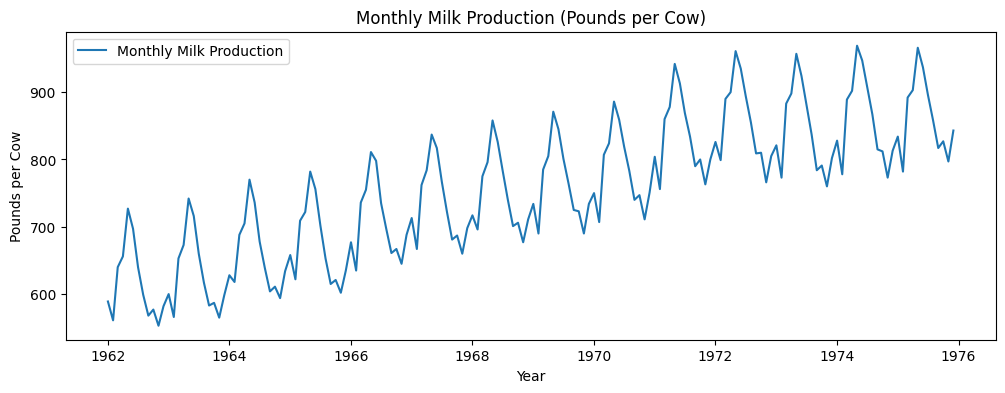

In [14]:
plt.figure(figsize=(12,4))
plt.plot(milk["Milk"], label="Monthly Milk Production")
plt.title("Monthly Milk Production (Pounds per Cow)")
plt.xlabel("Year")
plt.ylabel("Pounds per Cow")
plt.legend()
plt.show()


## Feature Engineering for Milk Production

We now create:

1. **Lag features**  
   - `lag_1`, `lag_12` (previous month and same month last year)

2. **Rolling features**  
   - 12-month rolling mean and standard deviation

3. **Calendar features**  
   - One-hot encoded month-of-year to capture seasonality


In [15]:
milk_feat = milk.copy()

# Lag features
milk_feat["lag_1"] = milk_feat["Milk"].shift(1)
milk_feat["lag_12"] = milk_feat["Milk"].shift(12)

# Rolling statistics
milk_feat["roll_mean_12"] = milk_feat["Milk"].rolling(window=12).mean()
milk_feat["roll_std_12"] = milk_feat["Milk"].rolling(window=12).std()

# Calendar features
milk_feat["month"] = milk_feat.index.month
milk_feat = pd.get_dummies(milk_feat, columns=["month"], drop_first=True)

milk_feat.head(15)


,Milk,lag_1,lag_12,roll_mean_12,roll_std_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Month,,,,,,,,,,,,,,,,
1962-01-01,589,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1962-02-01,561,589.0,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False
1962-03-01,640,561.0,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False
1962-04-01,656,640.0,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False
1962-05-01,727,656.0,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,False,False
1962-06-01,697,727.0,NaN,NaN,NaN,False,False,False,False,True,False,False,False,False,False,False
1962-07-01,640,697.0,NaN,NaN,NaN,False,False,False,False,False,True,False,False,False,False,False
1962-08-01,599,640.0,NaN,NaN,NaN,False,False,False,False,False,False,True,False,False,False,False
1962-09-01,568,599.0,NaN,NaN,NaN,False,False,False,False,False,False,False,True,False,False,False


## Preparing the Supervised Dataset

We drop rows with NaNs caused by shifting and rolling.  
Then we define:

- **X**: all engineered feature columns  
- **y**: the original milk production values


In [16]:
milk_model = milk_feat.dropna()

X_milk = milk_model.drop("Milk", axis=1)
y_milk = milk_model["Milk"]

X_milk.head(), y_milk.head()


(            lag_1  lag_12  roll_mean_12  roll_std_12  month_2  month_3  \
 Month                                                                    
 1963-01-01  582.0   589.0    616.666667    55.717360    False    False   
 1963-02-01  600.0   561.0    617.083333    55.280209     True    False   
 1963-03-01  566.0   640.0    618.166667    55.894110    False     True   
 1963-04-01  653.0   656.0    619.583333    57.141703    False    False   
 1963-05-01  673.0   727.0    620.833333    59.807013    False    False   
 
             month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
 Month                                                                        
 1963-01-01    False    False    False    False    False    False     False   
 1963-02-01    False    False    False    False    False    False     False   
 1963-03-01    False    False    False    False    False    False     False   
 1963-04-01     True    False    False    False    False    False     False   

In [17]:
X_milk_train, X_milk_test, y_milk_train, y_milk_test = train_test_split(
    X_milk, y_milk, test_size=0.2, shuffle=False
)

len(X_milk_train), len(X_milk_test)


(124, 32)

## Naive Baseline: Predict Next Month = This Month

As before, we use a simple baseline:

> Predict next month’s milk production as equal to this month’s production.

This baseline is easy to compute and gives us a reference MAE.


In [18]:
naive_milk_preds = X_milk_test["lag_1"].values
naive_milk_mae = mean_absolute_error(y_milk_test, naive_milk_preds)
naive_milk_mae


40.84375

In [19]:
rf_milk = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

rf_milk.fit(X_milk_train, y_milk_train)

rf_milk_preds = rf_milk.predict(X_milk_test)
rf_milk_mae = mean_absolute_error(y_milk_test, rf_milk_preds)
rf_milk_mae


15.511406250000007

## Comparing Model vs Baseline

We compare:

- **Naive MAE** (lag_1 only)  
- **Random Forest MAE** (lags + rolling + month dummies)

A lower MAE for the Random Forest indicates that:

- It exploits both **recent history** (`lag_1`, `lag_12`)  
- And **seasonal shape** (month dummies, rolling features)  
- To forecast milk production better than a trivial persistence model.


In [20]:
print("Naive baseline MAE:", naive_milk_mae)
print("Random Forest MAE:", rf_milk_mae)


Naive baseline MAE: 40.84375
Random Forest MAE: 15.511406250000007


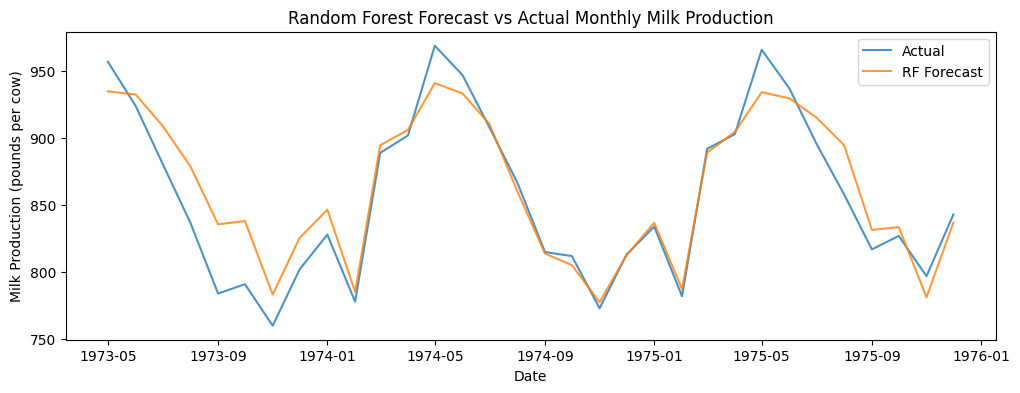

In [21]:
plt.figure(figsize=(12,4))
plt.plot(y_milk_test.index, y_milk_test.values, label="Actual", alpha=0.8)
plt.plot(y_milk_test.index, rf_milk_preds, label="RF Forecast", alpha=0.8)
plt.title("Random Forest Forecast vs Actual Monthly Milk Production")
plt.xlabel("Date")
plt.ylabel("Milk Production (pounds per cow)")
plt.legend()
plt.show()


## One-Step-Ahead Milk Production Forecast

To forecast the next month:

1. Take the last row with all engineered features  
2. Drop the target  
3. Run it through the trained Random Forest  
4. Interpret the result as the forecasted milk production for the next month


In [22]:
last_milk_row = milk_feat.tail(1)
X_milk_future = last_milk_row.drop("Milk", axis=1)

future_milk = rf_milk.predict(X_milk_future)[0]
future_milk


836.955

## References (Example 3)

- Hyndman, R. J., & Athanasopoulos, R. (2021). *Forecasting: Principles and Practice*. OTexts.  
- Brownlee, J. (2017). *Introduction to Time Series Forecasting with Python*. Machine Learning Mastery.  
- Dataset: *Monthly Milk Production (Pounds per Cow)*, available from the Plotly datasets repository.  
- pandas Documentation: https://pandas.pydata.org  
- scikit-learn Documentation: https://scikit-learn.org


# 📺 Video Demonstrations

Below are the supporting YouTube videos for each forecasting example.

---

## **Example 2 – Airline Passenger Forecasting**

### 🎬 Story-Style Explanation  
https://youtu.be/2qoi3dUfSow  

---

## **Example 3 – Monthly Milk Production Forecasting**

### 🎬 Story-Style Explanation  
https://youtu.be/2qoi3dUfSow  